## Predicting Movie Reviews with Classification Learning Models 

Data: **IMDB Dataset of 50K Movie Reviews**
(https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

This project analyzes a dataset with 50000 IMDb movie reviews. Each review comes with a sentiment: positive or negative. Our objective is to use NLP techniques in order to predict whether or not a moview review will be positive or negative. In order to do so two methods were implemented:


1. Using sklearn's TfidfVectorizer to create its own sentiment dictionary with 2000 features
2. Using a preset sentiment lexicon dictionary as our features


Analysis will be done on both of these approaches to explore the strenghts and weaknesses each method has to offer. Most importantly, we will see which technique yields the most consistent predictions.

Many different models will be implemented throughout this analysis. These models can be retrained and refined to continue predicting movie review sentiment:


1. Logistic Regression
2. Linear Discriminant Analysis
3. Quadratic Discriminant Analysis
4. K Nearest Neighbors
5. K fold Cross Validation for K Nearest Neighbors


PCA will be implemented for dimensional reduction as necessary. Other dimensional reduction techniques may be used if called for. 


*This file contains all programming done by Joshua Susanto*

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import sklearn
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, cohen_kappa_score
from datetime import datetime
import numpy.linalg as la
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Exploratory Analysis

In [2]:
# Read dataset
full_data = pd.read_csv('IMDB Dataset.csv')
full_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
# Positive Sentiment Lexicon
file = open("positive-words.txt", "r")
pos_words = file.read()
file.close()

pos_words = pos_words.splitlines()
pos_words = pos_words[1:]
pos_words[0:20]

['a+',
 'abound',
 'abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible',
 'acclaim',
 'acclaimed',
 'acclamation',
 'accolade',
 'accolades',
 'accommodative',
 'accomodative',
 'accomplish',
 'accomplished',
 'accomplishment',
 'accomplishments',
 'accurate',
 'accurately']

In [5]:
# Negative Sentiment Lexicon
file = open("negative-words.txt", "r")
neg_words = file.read()
file.close()

neg_words = neg_words.splitlines()
neg_words = neg_words[1:]
neg_words[0:20]

['2-faced',
 '2-faces',
 'abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate',
 'abomination',
 'abort',
 'aborted',
 'aborts',
 'abrade',
 'abrasive',
 'abrupt',
 'abruptly',
 'abscond',
 'absence',
 'absent-minded',
 'absentee',
 'absurd']

In [6]:
full_data['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [11]:
# First document
full_data['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

## Preprocessing

Lots of things to clean:
- capitalization
- normalization of words
- punctuation
- line break errors
- stop words

TF-IDF will do most of these things implicitly, but must do some of these steps manually to check the initial distribution of words for the sake of exploratory analysis.

In [12]:
# removing line break errors
full_data['review'] = full_data['review'].apply(lambda x:re.sub('br', '', x))
full_data['review'] = full_data['review'].apply(lambda x:re.sub('/', '', x))
full_data['review'] = full_data['review'].apply(lambda x:re.sub('>', '', x))
full_data['review'] = full_data['review'].apply(lambda x:re.sub('<', '', x))

# lowercase
full_data['review'] = full_data['review'].apply(lambda x:x.lower())

full_data['review'][0]

"one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this is exactly what happened with me.  the first thing that struck me about oz was its utality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.  it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.  i would say the main appeal of the show is due to the fact that it goes where other show

In [14]:
# tokenize data
full_data['tokenized'] = full_data['review'].apply(lambda x:word_tokenize(x))
print(full_data['tokenized'][0])

['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'oz', 'episode', 'you', "'ll", 'be', 'hooked', '.', 'they', 'are', 'right', ',', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me', '.', 'the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'utality', 'and', 'unflinching', 'scenes', 'of', 'violence', ',', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', '.', 'trust', 'me', ',', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', '.', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', ',', 'sex', 'or', 'violence', '.', 'its', 'is', 'hardcore', ',', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', '.', 'it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'penitentary', '.', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city', ',', 'an', 'experimental',

In [15]:
# set stop words, using first article as a test
stop_words = set(stopwords.words('english'))

# lowecase removal example
full_data['tokenized'][0] = [w.lower() for w in full_data['tokenized'][0]]

# removing stopwords, example with the first review
full_data['tokenized'][0] = [w for w in full_data['tokenized'][0] if not w in stop_words] 
full_data['tokenized'][0] = [w for w in full_data['tokenized'][0] if not w =='.']
full_data['tokenized'][0] = [w for w in full_data['tokenized'][0] if not w == ',']
full_data['tokenized'][0] = [w for w in full_data['tokenized'][0] if not w == "n't"]
full_data['tokenized'][0] = [w for w in full_data['tokenized'][0] if not w == "'ll"]

# stemming example
porter = nltk.PorterStemmer()
full_data['tokenized'][0]  = [porter.stem(w) for w in full_data['tokenized'][0]]

print(full_data['tokenized'][0])

['one', 'review', 'mention', 'watch', '1', 'oz', 'episod', 'hook', 'right', 'exactli', 'happen', 'first', 'thing', 'struck', 'oz', 'utal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'heart', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violenc', 'hardcor', 'classic', 'use', 'word', 'call', 'oz', 'nicknam', 'given', 'oswald', 'maximum', 'secur', 'state', 'penitentari', 'focus', 'mainli', 'emerald', 'citi', 'experiment', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privaci', 'high', 'agenda', 'em', 'citi', 'home', 'mani', '..', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', '....', 'scuffl', 'death', 'stare', 'dodgi', 'deal', 'shadi', 'agreement', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goe', 'show', 'would', 'dare', 'forget', 'pretti', 'pictur', 'paint', 'mainstream', 'audienc', 'forget', 'charm', 'forget', 'romanc', '...', 'oz', 'mess', 'a

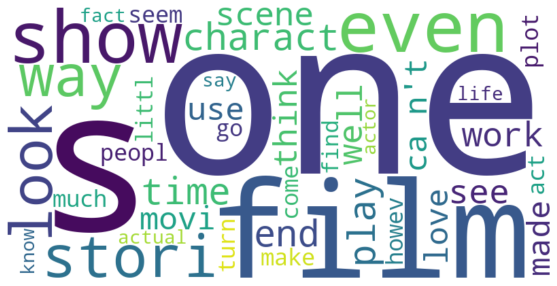

In [15]:
# join all text
all_text = " ".join(full_data['review'].astype(str))

# tokenize all text
all_text_tokenized = word_tokenize(all_text)

# remove stop words
filtered_tokens = [word for word in all_text_tokenized if word not in stop_words]

# stem words
porter = nltk.PorterStemmer()
filtered_tokens  = [porter.stem(x) for x in filtered_tokens]

# join the filtered tokens into a single string
filtered_text = " ".join(filtered_tokens)

# wordcloud generation
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color = "white").generate(filtered_text)

# plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### General TF-IDF Dictionary

This dictionary is created from the data itself rather than using a preexisting dictionary. The dictionary is created by taking the 2000 words with the highest TF-IDF across all potential features. We will be observing the difference between forming our own dictionary and using a preset sentiment lexicon as our TF-IDF dictionary.

In [16]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features = 2000, stop_words='english') # max features: max_number of keywords to consider.
X = vectorizer.fit_transform(full_data['review']) # tf-idf conversion
feature_names = vectorizer.get_feature_names() # top 2000 terms (dictionary)
print(X.shape)

(50000, 2000)


In [17]:
print(X)

  (0, 1808)	0.10252703711101174
  (0, 1775)	0.1105697221561603
  (0, 1892)	0.09321004143019412
  (0, 595)	0.08582041756149543
  (0, 1607)	0.11541693374580107
  (0, 1688)	0.09798807337084531
  (0, 990)	0.08681388433929843
  (0, 1835)	0.08851194271941382
  (0, 301)	0.09222141276510981
  (0, 1141)	0.0887817096832035
  (0, 1252)	0.08879352031493697
  (0, 974)	0.08556685560749269
  (0, 777)	0.11705801996451702
  (0, 1027)	0.11603948282689776
  (0, 771)	0.06384640747985053
  (0, 1749)	0.10397049761169333
  (0, 453)	0.10593216675935946
  (0, 1925)	0.07163880760069201
  (0, 1419)	0.10838053436424794
  (0, 372)	0.07911781832070525
  (0, 1732)	0.1183821195629724
  (0, 1194)	0.10972503731485306
  (0, 1513)	0.06528398706379836
  (0, 1136)	0.09688550710532583
  (0, 488)	0.059981290839883475
  :	:
  (49999, 1020)	0.13294050430526158
  (49999, 1855)	0.14809008397096168
  (49999, 986)	0.15460034029785846
  (49999, 1510)	0.15694484632625766
  (49999, 265)	0.15597015171297327
  (49999, 1828)	0.130711969

In [18]:
print(feature_names[1:200])

['10', '100', '1010', '11', '12', '13', '15', '20', '30', '40', '50', '60', '70', '70s', '80', '80s', '810', '90', 'ability', 'able', 'absolute', 'absolutely', 'absurd', 'academy', 'accent', 'accept', 'accident', 'according', 'accurate', 'act', 'acted', 'acting', 'action', 'actions', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'adam', 'adaptation', 'add', 'added', 'addition', 'adds', 'admit', 'adult', 'adults', 'adventure', 'advice', 'affair', 'afraid', 'african', 'age', 'aged', 'agent', 'ages', 'ago', 'agree', 'ahead', 'ain', 'air', 'al', 'alan', 'alex', 'alice', 'alien', 'aliens', 'alive', 'allen', 'allow', 'allowed', 'allows', 'amazing', 'america', 'american', 'americans', 'amusing', 'ancient', 'andy', 'angel', 'angry', 'animal', 'animals', 'animated', 'animation', 'ann', 'anna', 'anne', 'annoying', 'answer', 'anthony', 'anti', 'anybody', 'anymore', 'apart', 'apartment', 'apparent', 'apparently', 'appeal', 'appear', 'appearance', 'appeared', 'appears', '

In [ ]:
# (don't run this lol) export tf-idf matrix as a file

dense_tfidf = X.toarray()

# combine matrix w/ original dataset
data_with_tfidf = df_with_tfidf = pd.concat([full_data, pd.DataFrame(dense_tfidf, columns = feature_names)], axis=1)

# csv export
data_with_tfidf.to_csv('tfidf_data.csv', index=False)

In [19]:
# print a subset, this data is sparse which is helpful
print(dense_tfidf[:10, :10])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.10802464 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.20267966 0.         0.        ]
 [0.         0.11515601 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.

there are two different methods to consider:


- finding the tf-idf dictionary on the general dataset, obtaining the 2000 highest tfidf words as the predictors
- considering words from a premade dictionary, we calculate the tf-idfs for the positive negative sentiment lexicon to build our model

### Sentiment Lexicon TF-IDF Dictionary

Conversely, this dictionary was created using a sentiment lexicon dataset found in kaggle (https://www.kaggle.com/datasets/nltkdata/opinion-lexicon).

In [20]:
# combine both positive and negative words into a single list
all_lex = pos_words + neg_words
print(len(all_lex))

# create combined dictionary
lex_dict = {index: key for index, key in enumerate(all_lex)}

6789


In [21]:
# TF-IDF
terms = set(list(lex_dict.values())) # obtain all unique values
vectorizer = TfidfVectorizer(stop_words = 'english', vocabulary = terms) 
X_lex = vectorizer.fit_transform(full_data['review']) # tf-idf conversion
feature_names_lex = vectorizer.get_feature_names() 
print(X_lex.shape) # 3 common terms between the positive and negative lexicon

(50000, 6786)


In [22]:
# converting to dense array
dense_lex = X_lex.toarray()
print(dense_lex.sum(axis=0, dtype='float'))

[  0.           0.           0.         ...   6.28005141   3.81024337
 197.49939983]


In [23]:
print(dense_lex.shape)

(50000, 6786)


In [423]:
# [DO NOT RUN] export lexicon tf-idf matrix as a file

# combine matrix w/ original dataset
data_with_tfidf_lex =  pd.concat([full_data, pd.DataFrame(dense_lex, columns = feature_names_lex)], axis=1)

# csv export
data_with_tfidf_lex.to_csv('tfidf_data_lexicon.csv', index=False)

## Logistic Regression (No Dimensional Reduction)

For all following models (other than Cross Validation), a 50:50 train test split will be implemented due to prior knowledge of category distribution being perfeclty split. This is not regular practice when the distribution of our target variable is unknown.

### General TF-IDF

In [24]:
# convert labels into numeric
label_mapping = {'positive': 1, 'negative': 0}
full_data['y'] = [label_mapping[i] for i in full_data['sentiment']]
print(full_data['y'].head(),'\n',full_data['sentiment'].head())

# train test split
X_train, X_test, y_train, y_test = train_test_split(dense_tfidf, full_data['y'], test_size = 0.5, random_state = 42)

# check split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

0    1
1    1
2    1
3    0
4    1
Name: y, dtype: int64 
 0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object
(25000, 2000) (25000, 2000) (25000,) (25000,)


In [25]:
# set start time
start_time = datetime.now()

# initialize model
model = LogisticRegression()

# fit logistic regression model
model.fit(X_train, y_train)

# predict testing data
y_pred = model.predict(X_test)

# end time
end_time = datetime.now()

# model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("computation time:", end_time - start_time)

Accuracy: 0.8736
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12483
           1       0.86      0.89      0.88     12517

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

computation time: 0:00:03.975988


### Sentiment Lexicon TF-IDF

In [26]:
# train test split
X_lex_train, X_lex_test, y_lex_train, y_lex_test = train_test_split(dense_lex, full_data['y'], test_size = 0.5, random_state = 42)

# check split
print(X_lex_train.shape, X_lex_test.shape, y_lex_train.shape, y_lex_test.shape)

(25000, 6786) (25000, 6786) (25000,) (25000,)


In [27]:
# set start time
start_time = datetime.now()

# model training and testing
model = LogisticRegression()
model.fit(X_lex_train, y_lex_train)
y_lex_pred = model.predict(X_lex_test)
accuracy = accuracy_score(y_lex_test, y_lex_pred)

# end time
end_time = datetime.now()

# accuracy report
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_lex_test, y_lex_pred))
print("computation time:", end_time - start_time)

Accuracy: 0.8544
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     12483
           1       0.84      0.87      0.86     12517

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

computation time: 0:00:19.814399


We see a fairly strong testing accuracy with both of our logistic regression models, with each of them having accuracy above 0.85 and fairly balanced precision and recall. However, we see that our original dictionary ever so slightly edges out our premade dictionary as well as having a much easier computational load. This is only one of many models, and we can obviously account the difference in computation speed due to our premade dictionary having 3x as many predictors. Yet, we expect a tradeoff of having higher accuracy. There are many other models to consider, each with potentially varying dergees of success, including using dimensionality reduction techniques to maybe even the playing field in terms of computational speed:
- KNN 
- K-fold Cross Validation
- LDA and QDA

## Principal Component Analysis

### PCA with our general matrix

In [29]:
# singular value decomposition
U,S,VT = np.linalg.svd(dense_tfidf, full_matrices=False)

In [30]:
# check dimensions
print(U.shape, S.shape, VT.shape)

(50000, 2000) (2000,) (2000, 2000)


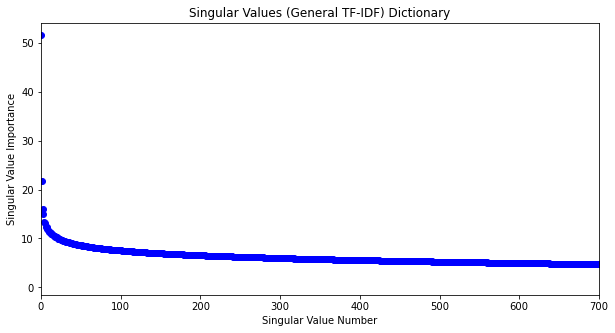

In [31]:
# visualization of our singular values
plt.figure(figsize=(10, 5))
plt.plot(S,'bo')
plt.title('Singular Values (General TF-IDF) Dictionary')
plt.ylabel("Singular Value Importance")
plt.xlabel("Singular Value Number")
ax = plt.gca()
ax.set_xlim([0, 700])
plt.show()

As expected we see a strong decrese in our singular values after the first few. There continues to be a steady decline which eventually plateus. However we may be losing too much information by just taking the first SVs that before the plateau. A better way to decide what dimension to reduce to would be to calculate the variance of our singular values and try to retain 80% of the variance as follows.

In [32]:
variance = []
for i in range(0,2001):
    variance.append(np.sum(S[0:i]**2)/np.sum(S**2))
print(variance[1:10])

[0.053011756624713316, 0.06248654460634709, 0.06756007336963281, 0.07211386792480809, 0.07568834689189696, 0.07914657169899045, 0.08223586597250161, 0.08526547488450971, 0.08813443225709636]


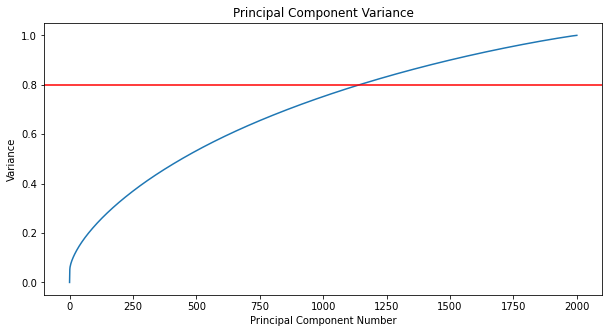

In [33]:
# visualization of our variance
plt.figure(figsize=(10, 5))
plt.plot(variance)
plt.axhline(y = 0.8, color='r', linestyle='-')
plt.title('Principal Component Variance')
plt.ylabel("Variance")
plt.xlabel("Principal Component Number")
plt.show()

### PCA with our Sentiment Lexicon Matrix

In [34]:
# singular value decomposition
U_lex,S_lex,VT_lex = np.linalg.svd(dense_lex, full_matrices=False)

In [35]:
# check dimensions
print(U_lex.shape, S_lex.shape, VT_lex.shape)

(50000, 6786) (6786,) (6786, 6786)


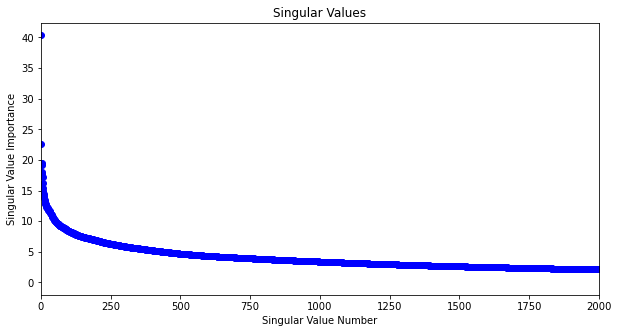

In [36]:
# plot the singular values
plt.figure(figsize=(10, 5))
plt.plot(S_lex,'bo')
plt.title('Singular Values')
plt.ylabel("Singular Value Importance")
plt.xlabel("Singular Value Number")
ax = plt.gca()
ax.set_xlim([0, 2000])
plt.show()

In [37]:
variance_lex = []
for i in range(0,6787):
    variance_lex.append(np.sum(S_lex[0:i]**2)/np.sum(S_lex**2))
print(variance_lex[1:10])

[0.03257243579429631, 0.04279116719184263, 0.05044335668696506, 0.05779143750707675, 0.06428208596911633, 0.07058318770552668, 0.07647063356942149, 0.08178821726922723, 0.08649885334566224]


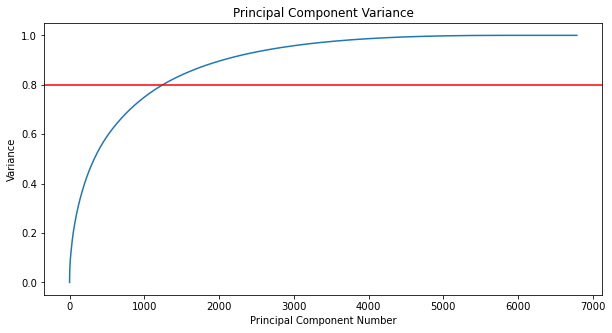

In [38]:
# plot the cumulative variance
plt.figure(figsize=(10, 5))
plt.plot(variance_lex)
plt.axhline(y = 0.8, color='r', linestyle='-')
plt.title('Principal Component Variance')
plt.ylabel("Variance")
plt.xlabel("Principal Component Number")
plt.show()

From our singular value analysis we see that in terms of explained variance, around 80% of it can be accounted for with around the first 1100 principal components, for both matrices conveniently. This would mean we would need to reduce our dimension by about 900 and 5600 respectively by taking the first 1100 principal components as our new feature matrix. Taking these principal components we can now perform logistic regression (as well as other more intensive models) with reduced dimensions.

## Logistic Regression (with reduced dimensions)

### General Matrix

In [39]:
# taking the first 1100 PCs of our general dictionary matrix
X_PCA = dense_tfidf@VT[0:1100,:].T
X_PCA.shape 

(50000, 1100)

In [40]:
# train test split with our PCA data
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, full_data['y'], test_size = 0.5, random_state = 42)

print(X_PCA_train.shape, X_PCA_test.shape, y_PCA_train.shape, y_PCA_test.shape)

(25000, 1100) (25000, 1100) (25000,) (25000,)


In [41]:
start = datetime.now()

# initialize model
model = LogisticRegression()

# fit logistic regression model
model.fit(X_PCA_train, y_PCA_train)

# predict testing data
y_PCA_pred = model.predict(X_PCA_test)

end = datetime.now()

# model accuracy
accuracy = accuracy_score(y_PCA_test, y_PCA_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_PCA_test, y_PCA_pred))
print("computation time:", end - start)

Accuracy: 0.87324
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12483
           1       0.86      0.89      0.88     12517

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

computation time: 0:00:01.988305


### Sentiment Lexicon Matrix

In [42]:
# taking the first 1100 PCs of our opinion lexicon dictionary matrix
X_lex_PCA = dense_lex@VT_lex[0:1100,:].T
X_lex_PCA.shape 

(50000, 1100)

In [43]:
# train test split with new reduced matrix
X_lex_PCA_train, X_lex_PCA_test, y_lex_PCA_train, y_lex_PCA_test = train_test_split(X_lex_PCA, full_data['y'], test_size = 0.5, random_state = 42)

print(X_lex_PCA_train.shape, X_lex_PCA_test.shape, y_lex_PCA_train.shape, y_lex_PCA_test.shape)

(25000, 1100) (25000, 1100) (25000,) (25000,)


In [44]:
# fitting, training, and testing our logistic regression model
start = datetime.now()
model = LogisticRegression()
model.fit(X_lex_PCA_train, y_lex_PCA_train)
y_lex_PCA_pred = model.predict(X_lex_PCA_test)
end = datetime.now()

# model accuracy and diagnosis
accuracy = accuracy_score(y_lex_PCA_test, y_lex_PCA_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_lex_PCA_test, y_lex_PCA_pred))
print("computation time", end - start)

Accuracy: 0.85388
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     12483
           1       0.84      0.87      0.86     12517

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

computation time 0:00:02.459250


Obviously, we can't stop a certain amount of information from being loss by reducing the dimensionality of our data. However, with our reduction we were able to still get a very strong testing accuracy and cut our computaional time significantly. Looking at our diagnostic tables, our model's quality hardly dipped and we were still able to save much computational rigor with this method, especially with our sentiment lexicon matrix. (Going from 4 to 2 seconds and 20 to 2.5 seconds respectively) Since the data is sparse enough to run a normal logistic regression without any dimensional reduction in a reasonable time, a normal logistic regression is still the preferable method in this scenario. However, this is a good practice to observe the tradeoff between information loss and computational efficiency and how helpful PCA can be with less sparse data.

### [IGNORE] Data Writing and Export

In [45]:
# export reduced train and test data

# train 
df_train_pca = pd.DataFrame(X_PCA_train)
df_train_pca.to_csv('xtrain_pca.csv', index=False)

# test 
df_test_pca = pd.DataFrame(X_PCA_test)
df_test_pca.to_csv('xtest_pca.csv', index=False)

In [46]:
# export sentiment lexicon reduced train and test data

# train 
df_train_lex_pca = pd.DataFrame(X_lex_PCA_train)
df_train_lex_pca.to_csv('xtrain_lex_pca.csv', index=False)

# test 
df_test_lex_pca = pd.DataFrame(X_lex_PCA_test)
df_test_lex_pca.to_csv('xtest_lex_pca.csv', index=False)

In [47]:
# exporting labels

# train 
df_train_labels = pd.DataFrame(y_PCA_train)
df_train_labels.to_csv('y_pca_train', index=False)

# test
df_test_labels = pd.DataFrame(y_PCA_test)
df_test_labels.to_csv('y_pca_test', index=False)

In [48]:
# exporting labels for sentiment lexicon data

# train 
df_train_lex_labels = pd.DataFrame(y_lex_PCA_train)
df_train_lex_labels.to_csv('y_lex_PCA_train', index=False)

# test
df_test_lex_labels = pd.DataFrame(y_lex_PCA_test)
df_test_lex_labels.to_csv('y_lex_PCA_test', index=False)

## K-Nearest Neighbors

A general practice with K-nearest neighbors is to set K to be the square root of the amount of observations. We will try this with the PCA data due to the computational efficiency that PCA brings. It may be interesting to consider how this experiment will compare when using the full data with a reduced K for a computational efficiency v. information loss trade-off. Hence we will observe another experiment that takes a third of this k value but utilizes all predictors.

### General Data

In [45]:
# start time
start = datetime.now()

# choosing k = sqrt(N) which is about 157
k_neighbors = 157

# create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_model.fit(X_PCA_train, y_PCA_train)

# predictions and evaluation for KNN
knn_predictions = knn_model.predict(X_PCA_test)
knn_accuracy = accuracy_score(y_PCA_test, knn_predictions)

# end time
end = datetime.now()

print("157-Nearest Neighbors:")
print(f"Accuracy: {knn_accuracy}")
print("Classification Report:")
print(classification_report(y_PCA_test, knn_predictions))
print("computation time:", end - start)

157-Nearest Neighbors:
Accuracy: 0.69204
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.43      0.58     12483
           1       0.63      0.95      0.76     12517

    accuracy                           0.69     25000
   macro avg       0.76      0.69      0.67     25000
weighted avg       0.76      0.69      0.67     25000

computation time: 0:00:40.562738


In [46]:
# start time
start = datetime.now()

# reduced k but using full data
k_neighbors = 50

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_model.fit(X_train, y_train)

# Predictions and evaluation for KNN
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)

# end time
end = datetime.now()

print("50-Nearest Neighbors:")
print(f"Accuracy: {knn_accuracy}")
print("Classification Report:")
print(classification_report(y_test, knn_predictions))
print("computation time:", end - start)

50-Nearest Neighbors:
Accuracy: 0.78108
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77     12483
           1       0.77      0.81      0.79     12517

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000

computation time: 0:00:57.874427


With these results we are truly able to see the tradeoff between information loss and computational efficiency with PCA and KNN. With using k = 157 we see a notable dip in accuracy as compared with using k = 50 with all features, yet even with a significantly reduced k, using all features still ended up being much more computationally expensive. A balance between accuracy and time will likely be achieved by increasing k in the first case or decreasing k in the second case. 

### Sentiment Lexicon Data

In [47]:
# start time
start = datetime.now()

# choosing k = sqrt(N) which is about 157
k_neighbors = 157

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_model.fit(X_lex_PCA_train, y_lex_PCA_train)

# Predictions and evaluation for KNN
knn_predictions = knn_model.predict(X_lex_PCA_test)
knn_accuracy = accuracy_score(y_lex_PCA_test, knn_predictions)

# end time
end = datetime.now()

print("157-Nearest Neighbors:")
print(f"Accuracy: {knn_accuracy}")
print("Classification Report:")
print(classification_report(y_lex_PCA_test, knn_predictions))
print("computation time:", end - start)

157-Nearest Neighbors:
Accuracy: 0.6182
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.25      0.40     12483
           1       0.57      0.98      0.72     12517

    accuracy                           0.62     25000
   macro avg       0.75      0.62      0.56     25000
weighted avg       0.75      0.62      0.56     25000

computation time: 0:00:39.475601


In [48]:
# start time
start = datetime.now()

# reduced k but using full data
k_neighbors = 50

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_model.fit(X_lex_train, y_lex_train)

# Predictions and evaluation for KNN
knn_predictions = knn_model.predict(X_lex_test)
knn_accuracy = accuracy_score(y_lex_test, knn_predictions)

# end time
end = datetime.now()

print("k-Nearest Neighbors:")
print(f"Accuracy: {knn_accuracy}")
print("Classification Report:")
print(classification_report(y_lex_test, knn_predictions))
print("computation time:", end - start)

k-Nearest Neighbors:
Accuracy: 0.76876
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.62      0.73     12483
           1       0.71      0.91      0.80     12517

    accuracy                           0.77     25000
   macro avg       0.79      0.77      0.76     25000
weighted avg       0.79      0.77      0.76     25000

computation time: 0:02:24.567093


Due to the disproportionate amount of features in the sentiment lexicon dictionary we see an clear spike in computation time when using its full data. However, we seemed to sustain more information loss with our lexicon dictionary, with accuracy dipping to the low 60s. In general, we've so far noticed our original dictionary outperforming both in terms of accuracy and computational speed. After PCA our models in particular seem to start struggling in overpredicting a negative review than a positive review. 

## Linear Discriminant Analysis

### General Data (with PCA)

In [63]:
# initialize start time
start_time = datetime.now()

# initialize LDA model and fit this model
lda = LinearDiscriminantAnalysis()
lda.fit(X_PCA_train, y_PCA_train)

# predict with the testing data
lda_predictions = lda.predict(X_PCA_test)

# evaluate our LDA model
lda_accuracy = accuracy_score(y_PCA_test, lda_predictions)
lda_classification_report = classification_report(y_PCA_test, lda_predictions)

# end time
end_time = datetime.now()

print("Linear Discriminant Analysis (LDA) Results:")
print(f"Accuracy: {lda_accuracy:}")
print("Classification Report:")
print(lda_classification_report)
print("Computation Time:", end_time - start_time)

Linear Discriminant Analysis (LDA) Results:
Accuracy: 0.86864
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87     12483
           1       0.85      0.89      0.87     12517

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Computation Time: 0:00:13.966696


### General Data (No PCA)

In [64]:
# initialize start time
start_time = datetime.now()

# model fitting and diagnosis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

lda_predictions = lda.predict(X_test)

lda_accuracy = accuracy_score(y_test, lda_predictions)
lda_classification_report = classification_report(y_test, lda_predictions)

# end time
end_time = datetime.now()

print("Linear Discriminant Analysis (LDA) (NO PCA) Results:")
print(f"Accuracy: {lda_accuracy:}")
print("Classification Report:")
print(lda_classification_report)
print("Computation Time:", end_time - start_time)

Linear Discriminant Analysis (LDA) (NO PCA) Results:
Accuracy: 0.86524
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     12483
           1       0.85      0.88      0.87     12517

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Computation Time: 0:00:31.814895


### Sentiment Lexicon Data

In [65]:
# initialize start time
start_time = datetime.now()

# initialize LDA model, fit, and evaluate model
lda = LinearDiscriminantAnalysis()
lda.fit(X_lex_PCA_train, y_lex_PCA_train)

lda_predictions = lda.predict(X_lex_PCA_test)

lda_accuracy = accuracy_score(y_lex_PCA_test, lda_predictions)
lda_classification_report = classification_report(y_lex_PCA_test, lda_predictions)

# end time
end_time = datetime.now()

print("Linear Discriminant Analysis (LDA) Results:")
print(f"Accuracy: {lda_accuracy}")
print("Classification Report:")
print(lda_classification_report)
print("Computation Time:", end_time - start_time)

Linear Discriminant Analysis (LDA) Results:
Accuracy: 0.84568
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84     12483
           1       0.83      0.87      0.85     12517

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Computation Time: 0:00:15.433693


## Quadratic Discriminant Analysis

### General Data

In [66]:
# initialize start time
start_time = datetime.now()

# initialize QDA model and fit this model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_PCA_train, y_PCA_train)

# predict with the testing data
qda_predictions = qda.predict(X_PCA_test)

# Evaluate QDA
qda_accuracy = accuracy_score(y_PCA_test, qda_predictions)
qda_classification_report = classification_report(y_PCA_test, qda_predictions)

# end time
end_time = datetime.now()

print("\nQuadratic Discriminant Analysis (QDA) Results:")
print(f"Accuracy: {qda_accuracy}")
print("Classification Report:")
print(qda_classification_report)
print("Computation Time:", end_time - start_time)


Quadratic Discriminant Analysis (QDA) Results:
Accuracy: 0.82172
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     12483
           1       0.82      0.83      0.82     12517

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Computation Time: 0:00:16.012062


### Sentiment Lexicon Data

In [67]:
# start time
start_time = datetime.now()

# initialize QDA model and fit this model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_lex_PCA_train, y_lex_PCA_train)

# predict 
qda_predictions = qda.predict(X_lex_PCA_test)

# evaluate 
qda_accuracy = accuracy_score(y_lex_PCA_test, qda_predictions)
qda_classification_report = classification_report(y_lex_PCA_test, qda_predictions)

# end time
end_time = datetime.now()

print("Quadratic Discriminant Analysis (QDA) Results:")
print(f"Accuracy: {qda_accuracy}")
print("Classification Report:")
print(qda_classification_report)
print("Computation Time:", end_time - start_time)

Quadratic Discriminant Analysis (QDA) Results:
Accuracy: 0.78488
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78     12483
           1       0.78      0.79      0.79     12517

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000

Computation Time: 0:00:19.812929


We observe that overall, LDA performs better tha QDA, with this difference being more pronounced within the sentiment lexicon dictionary. This may suggest that this matrix space in particular follow a more linear decision boundary rather than a quadratic one. Due to a simpler algorithm, we also see LDA being more computationally efficient. Different data will respond to different algorithms accordingly, ours seems to favor the decision boundary of LDA rather than QDA

## K-fold Cross Validation

### General Dictionary

In [142]:
# 5 fold cross-validation for k values from 1 to 29, initialize lists for CV scores and computation time
k_values = list(range(1, 30, 2))
cv_scores = []
time_diff = []

for k in k_values:
    # start time
    start = datetime.now()
    
    # initialize knn model for iteration k
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    # 5 fold CV score
    scores = cross_val_score(knn_model, X_PCA, full_data['y'], cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    
    # calculate computation time
    end = datetime.now()
    time_diff.append(end - start)
    

# converting datetime object into numeric
time_diff_sec = [x.total_seconds() for x in time_diff ]    


print(cv_scores)

[0.60664, 0.61888, 0.6298, 0.64084, 0.6478, 0.65634, 0.66082, 0.6653, 0.67066, 0.67432, 0.67776, 0.68156, 0.68462, 0.68642, 0.69014]


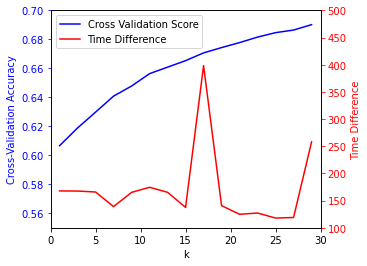

In [153]:
# plot the results to visualize performance and computation time vs. k

# initialize plots
fig, ax = plt.subplots()
fig.subplots_adjust(right = 0.75)
twin = ax.twinx()

# plot lines
plot1 = ax.plot(k_values, cv_scores, color = 'b', label = 'Cross Validation Score')
plot2 = twin.plot(k_values, time_diff_sec, color = 'r', label = 'Time Difference')

# set axis limits and labels
ax.set(xlim = (0, 30), ylim = (0.55, 0.7), xlabel = "k", ylabel = "Cross-Validation Accuracy")
twin.set(ylim = (100, 500), ylabel = "Time Difference")

# set axis colors
ax.yaxis.label.set_color('blue')
twin.yaxis.label.set_color('red')

# set tick colors
ax.tick_params(axis = 'y', colors = 'blue')
twin.tick_params(axis = 'y', colors = 'red')

# create legend
lines = plot1 + plot2
labels = [x.get_label() for x in lines]
ax.legend(lines, labels, loc=0)

plt.show()

### Sentiment Lexicon Dictionary

In [144]:
# 5 fold cross-validation for k values from 1 to 29, initialize lists for CV scores and computation time
k_values = list(range(1, 30, 2))
cv_scores_lex = []
time_diff_lex = []

for k in k_values:
    # start time
    start = datetime.now()
    
    # initialize knn model for iteration k
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    # 5 fold CV score
    scores = cross_val_score(knn_model, X_lex_PCA, full_data['y'], cv=5, scoring='accuracy')
    cv_scores_lex.append(scores.mean())
    
    # calculate computation time
    end = datetime.now()
    time_diff_lex.append(end - start)
    

# converting datetime object into numeric
time_diff_sec_lex = [x.total_seconds() for x in time_diff_lex ]    


print(cv_scores_lex)

[0.63552, 0.63784, 0.6413800000000001, 0.63388, 0.6242800000000001, 0.6126999999999999, 0.60392, 0.5955400000000001, 0.58788, 0.5824, 0.57972, 0.57768, 0.57774, 0.57868, 0.58212]


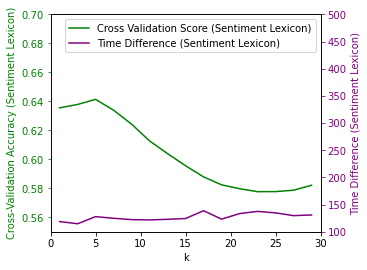

In [152]:
# plot the results to visualize performance and computation time vs. k

# initialize plots
fig, ax = plt.subplots()
fig.subplots_adjust(right = 0.75)
twin = ax.twinx()

# plot lines
plot1 = ax.plot(k_values, cv_scores_lex, color = 'g', label = 'Cross Validation Score (Sentiment Lexicon)')
plot2 = twin.plot(k_values, time_diff_sec_lex, color = 'purple', label = 'Time Difference (Sentiment Lexicon)')

# set axis limits and labels
ax.set(xlim = (0, 30), ylim = (0.55, 0.7), xlabel = "k", ylabel = "Cross-Validation Accuracy (Sentiment Lexicon)")
twin.set(ylim = (100, 500), ylabel = "Time Difference (Sentiment Lexicon)")

# set axis colors
ax.yaxis.label.set_color('g')
twin.yaxis.label.set_color('purple')

# set tick colors
ax.tick_params(axis = 'y', colors = 'g')
twin.tick_params(axis = 'y', colors = 'purple')

# create legend
lines = plot1 + plot2
labels = [x.get_label() for x in lines]
ax.legend(lines, labels, loc=0)

plt.show()

## Model Limitations and Improvements

All of our models had varying degrees of success, all being relatively solid at predicting the sentiment of movie reviews. However, there are still aspects of our process of creating and fitting the models that allow for improvement. 

Because our original dictionary outperformed the sentiment dictionary for every model, we suspect that our dictionary worked better because it is better suited for the context of our data. This could limit the generalizability of the dictionary for unknown data, since there are words that may be more commonly used for movies that are not included in our dictionary. Ultimately, creating a dictionary in which the predictors are drawn from the information we already have leads to some degree of implicit bias. As we obtain more information this bias decreases but in our case it is clearly present. 

In the future, it may be possible to automate the entire process of sentiment analysis for any context by developing an algorithm for generating a custom dictionary for any dataset. But within the confines of this experiment, a more effective method would be to utilize the tfidfVectorizer **after** the train-test split and consider multiple splits with cross validation. This would improve the reproducability of our model and help to remove any implicit biases present from our method. However, this would be extremely comutationally inefficient. So while our general dictionary worked better, the sentiment lexicon made dictionary may be a better general model for future predictions.

Moreover, because the dataset contained so many records, we sometimes encountered difficulty training our models, especially for KNN and any form of cross validation, which sometimes took hours to run. It is possible to reduce computation time with some algorithmic improvement; though, ultimately, this limitation is not unique to this study but rather an illustration of current technological limitations. 